In [1]:
using Plots
pyplot()

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = top-level scope at none:0
└ @ Core none:0


Plots.PyPlotBackend()

In [2]:
using NumericalIntegration
using FFTW

In [3]:
push!(LOAD_PATH, "../src/VlasovSolver/")
push!(LOAD_PATH, "../src/MaxwellSolver/")

using PFCNonUniform
using StrangSplitting
using PoissonFourier1D

# Linear Landau damping on uniform grid

Here we perform a linear Landau damping test of the scheme in the case of uniform grid.

Initial conditions for electrons are
$$
f(x, v) = \frac{1}{\sqrt{2\pi}}\exp\left\{-\frac{v^2}{2}\right\}\left(1 + \tilde n\cos kx\right)
$$
where velocities $v$ are normalised to a thermal velocity $v_{\rm th}$, concentration $n$ is normalized to equilibrium concentration $N_e$, spatial coordinate $x$ is normalized to $v_{\rm th} \over \omega_p$ where $\omega_p^2 = \frac{4\pi e^2 N_e}{m}$ is a plasma frequency ($e$ is the elemaentary charge and $m$ is the electron mass).

$k$ normalized to $\omega_p \over v_{\rm th}$ is a wave number. Here we verify the case $k \sim 1$ for which dispersion and Landau damping are significant.

Ions are supposed to be uniformly distributed and immobile.

For simulations below we choose: $k = 0.5$, $\tilde n = 0.01$

Simulations are performed on a uniform grid $x \in (\frac{\pi}{8},8\pi)$, $\Delta x = \frac{\pi}{8}$, $v \in (-4,4)$, $\Delta v = 0.1$, $t \in (0, 70)$, $\Delta t = 0.1$

In [10]:
x = collect(π/8:π/8:8π)
Δx = vcat([x[2]-x[1]], 0.5*(x[3:end] - x[1:end-2]), [x[end]-x[end-1]])
v = collect(-4:0.1:4)
Δv = vcat([v[2]-v[1]], 0.5*(v[3:end] - v[1:end-2]), [v[end]-v[end-1]])

advect_x! = make_advect_1D!(Δx)
advect_v! = make_advect_1D!(Δv)

fi = 1/sqrt(2π)*(@. exp(-0.5*(v)^2)) * (@. Δx/Δx)'
ni = integrate(v, fi)
Ni = integrate(x, ni)

f0 = 1/sqrt(2π)*(@. exp(-0.5*(v)^2)) * (@. (1.0 + 0.01*cos(0.5*x)))'
n0 = integrate(v, f0)
N0 = integrate(x, n0)
f0 *= Ni/N0;

f = copy(f0)

t = collect(0.0:0.1:70.0)
n = t * n0'

ε = similar(t)
ε_e = similar(ε)

ω = 2π*collect(0.0:1.0/(x[end]-x[1]+x[2]-x[1]):0.5/(x[2]-x[1]))
ω[1] = ω[2]
    
e = similar(x)

g = f';

In [11]:
function run()
    global f, g, t, n, e, ε, ε_e, ω
    for k in 1:length(t)-1
        Δt = t[k+1] - t[k]
        
        function vΔt(f)
            return v*Δt
        end
        
        function eΔt(f)
            n[k,:] = sum(f'.*Δv, dims=1)'
            solve_poisson!(e, ω, n[k,:]-ni, Δx)
            return e*Δt
        end
        
        make_time_step_2d!((g, f), (vΔt, eΔt), (advect_x!, advect_v!))
        
        ε_e[k] = integrate(x, e.^2)
        ε[k] = integrate(x, integrate(v, @. f*v^2)) + ε_e[k]
    end
    n[end,:] = sum(f.*Δv, dims=1)'
    solve_poisson!(e, ω, n[end,:]-ni, Δx)
    ε_e[end] = integrate(x, e.^2)
    ε[end] = integrate(x, integrate(v, @. f*v^2)) + ε_e[end]
    return
end

run (generic function with 1 method)

In [12]:
@time run()

  6.857111 seconds (121.49 M allocations: 4.054 GiB, 12.73% gc time)


Below we check damping of electric energy calculated as follows

$$
\varepsilon_e = \int \frac{E^2}{2} dx
$$

where $E$ is an electric filed normalized to $\frac{m\omega_p v_{\rm th}}{e}$.

We expect it to damp with the rate defined by the following expression:

$$
\gamma = \frac{\pi}{8\sqrt{2}}k^{-3}\exp\left(-\frac{1}{2k^2}\right)
$$

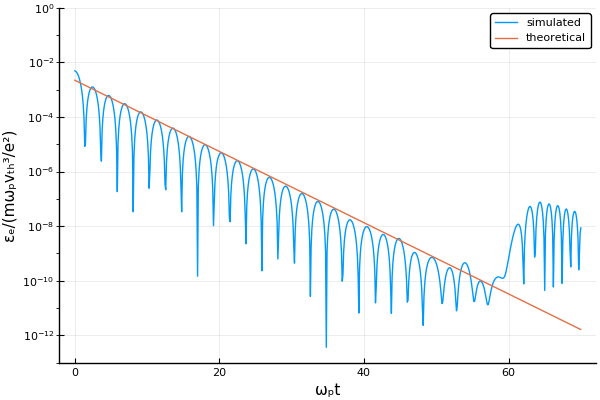

In [13]:
u = 1/0.5
γ = π/(8*√2)*u^3*exp(-0.5*u^2)
ε_th = ε_e[9]*exp.(-γ*(t.-t[9]))

plot(t, ε_e, yscale=:log10, label="simulated")
plot!(t, ε_th, yscale=:log10, label="theoretical")
ylims!(1e-13,1)
xlabel!("ωₚt")
ylabel!("εₑ/(mωₚvₜₕ³/e²)")

Here we see the great coincidence between simulations and the theory. We also see a well-known effect of oscillations recursion due to numerical artifact caused by finite resolution of veolcity space. It has been shown that the recursion time is of the order of $\pi/(k\Delta v)$ where $\Delta v$ is the velocity resolution. In our case this statement gives $t_{recur} \sim 62$ which is also in good coincidence with simulation results.

We also can check the dispersion relation for Laingmuir oscillations in warm plasma. We expect that the frequency will be equal to

$$
\omega_L = (\omega_p^2 + 3k^2)^{\frac12}
$$

Here is the spectrum of oscillations in the central point (we take time interval $t \in (0,50)$ where oscillations does not contain numerical artifacts).

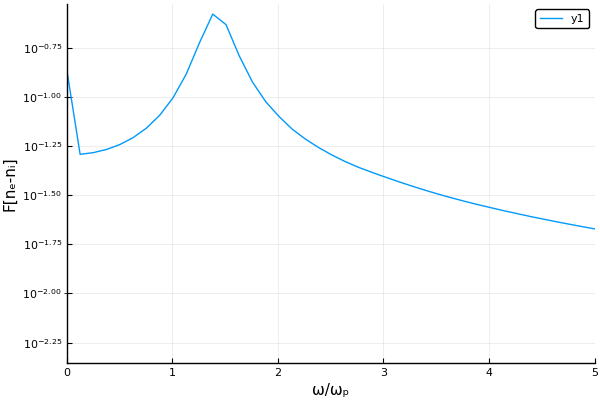

In [21]:
F = FFTW.rfft(n[1:500,end÷2].-ni[end÷2])
ω = 2π*collect(0.0:1.0/(t[501]-t[1]):0.5/(t[2]-t[1]))
plot(ω, abs.(F), yscale=:log10)
xlabel!("ω/ωₚ")
ylabel!("F[nₑ-nᵢ]")
xlims!(0,5)

Below we compare theoretical value for oscillations frequency and the one obtained numerically:

In [22]:
println("theoretical: ", sqrt(1 + 3*0.5^2))
println("numerical:   ", ω[argmax(abs.(F))])

theoretical: 1.3228756555322954
numerical:   1.382300767579509


Again we have a very good coincidence limited only by resolution of time step.

# Linear Landau damping on non-uniform grid

Now we perform a linear Landau damping test of the scheme in the case of non-uniform grid.

Initial conditions and simulation parameters are the same except for grid along velocity axis. Now it isn't uniform:

$v \in (-4,4)$,

$\Delta v = 0.05 \iff |v| < 1$,

$\Delta v = 0.1 \iff |v| > 1$

We also increase time resolution by factor of two.

In [50]:
x = collect(π/8:π/8:8π)
Δx = vcat([x[2]-x[1]], 0.5*(x[3:end] - x[1:end-2]), [x[end]-x[end-1]])
v = vcat(collect(-4:0.1:-1.1), collect(-1:0.05:1), collect(1.1:0.1:4))
Δv = vcat([v[2]-v[1]], 0.5*(v[3:end] - v[1:end-2]), [v[end]-v[end-1]])

advect_x! = make_advect_1D!(Δx)
advect_v! = make_advect_1D!(Δv)

fi = 1/sqrt(2π)*(@. exp(-0.5*(v)^2)) * (@. Δx/Δx)'
ni = integrate(v, fi)
Ni = integrate(x, ni)

f0 = 1/sqrt(2π)*(@. exp(-0.5*(v)^2)) * (@. (1.0 + 0.01*cos(0.5*x)))'
n0 = integrate(v, f0)
N0 = integrate(x, n0)
f0 *= Ni/N0;

f = copy(f0)

t = collect(0.0:0.05:70.0)
n = t * n0'

ε = similar(t)
ε_e = similar(ε)

ω = 2π*collect(0.0:1.0/(x[end]-x[1]+x[2]-x[1]):0.5/(x[2]-x[1]))
ω[1] = ω[2]
    
e = similar(x)

g = f';

In [51]:
function run()
    global f, g, t, n, e, ε, ε_e, ω
    for k in 1:length(t)-1
        Δt = t[k+1] - t[k]
        
        function vΔt(f)
            return v*Δt
        end
        
        function eΔt(f)
            n[k,:] = sum(f'.*Δv, dims=1)'
            solve_poisson!(e, ω, n[k,:]-ni, Δx)
            return e*Δt
        end
        
        make_time_step_2d!((g, f), (vΔt, eΔt), (advect_x!, advect_v!))
        
        ε_e[k] = integrate(x, e.^2)
        ε[k] = integrate(x, integrate(v, @. f*v^2)) + ε_e[k]
    end
    n[end,:] = sum(f.*Δv, dims=1)'
    solve_poisson!(e, ω, n[end,:]-ni, Δx)
    ε_e[end] = integrate(x, e.^2)
    ε[end] = integrate(x, integrate(v, @. f*v^2)) + ε_e[end]
    return
end

run (generic function with 1 method)

In [52]:
@time run()

 16.269433 seconds (302.55 M allocations: 10.090 GiB, 13.59% gc time)


Let us again check damping rate of electric energy and compare it to theoretical prediction

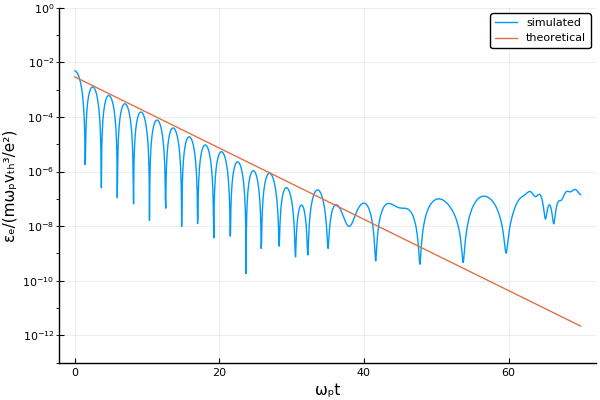

In [53]:
u = 1/0.5
γ = π/(8*√2)*u^3*exp(-0.5*u^2)
ε_th = ε_e[15]*exp.(-γ*(t.-t[15]))

plot(t, ε_e, yscale=:log10, label="simulated")
plot!(t, ε_th, yscale=:log10, label="theoretical")
ylims!(1e-13,1)
xlabel!("ωₚt")
ylabel!("εₑ/(mωₚvₜₕ³/e²)")

Again we see a good coincidence between simulations and theory. However for the non-uniform grid the rucursion effect comes to play earlier.

Now we check dispersion relation

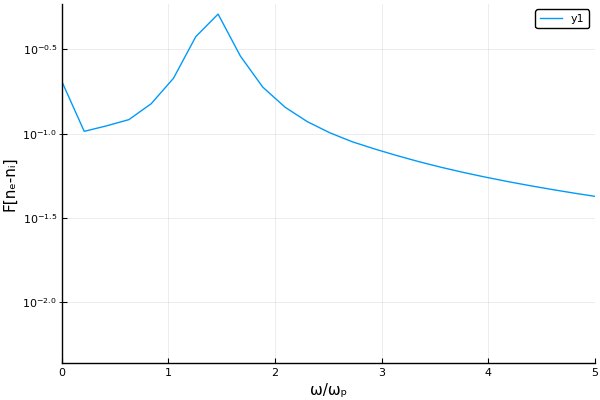

In [54]:
F = FFTW.rfft(n[1:600,end÷2].-ni[end÷2])
ω = 2π*collect(0.0:1.0/(t[601]-t[1]):0.5/(t[2]-t[1]))
plot(ω, abs.(F), yscale=:log10)
xlabel!("ω/ωₚ")
ylabel!("F[nₑ-nᵢ]")
xlims!(0,5)

In [55]:
println("theoretical: ", sqrt(1 + 3*0.5^2))
println("numerical:   ", ω[argmax(abs.(F))])

theoretical: 1.3228756555322954
numerical:   1.4660765716752369


We again have a good coincidence limited only by time resolition

# Non-linear Landau damping on non-uniform grid

Finaly we check the case of non-linear (strong) Landau damping using non-uniform grid. For this we increase initial perturbation of electron concentration to $\tilde n = 0.5$. To cope with increasing amplitude of oscillations we also increase the velocity domain to $(-6, 6)$

In [56]:
x = collect(π/8:π/8:8π)
Δx = vcat([x[2]-x[1]], 0.5*(x[3:end] - x[1:end-2]), [x[end]-x[end-1]])
v = vcat(collect(-6:0.1:-1.1), collect(-1:0.05:1), collect(1.1:0.1:6))
Δv = vcat([v[2]-v[1]], 0.5*(v[3:end] - v[1:end-2]), [v[end]-v[end-1]])

advect_x! = make_advect_1D!(Δx)
advect_v! = make_advect_1D!(Δv)

fi = 1/sqrt(2π)*(@. exp(-0.5*(v)^2)) * (@. Δx/Δx)'
ni = integrate(v, fi)
Ni = integrate(x, ni)

f0 = 1/sqrt(2π)*(@. exp(-0.5*(v)^2)) * (@. (1.0 + 0.5*cos(0.5*x)))'
n0 = integrate(v, f0)
N0 = integrate(x, n0)
f0 *= Ni/N0;

f = copy(f0)

t = collect(0.0:0.05:70.0)
n = t * n0'

ε = similar(t)
ε_e = similar(ε)

ω = 2π*collect(0.0:1.0/(x[end]-x[1]+x[2]-x[1]):0.5/(x[2]-x[1]))
ω[1] = ω[2]
    
e = similar(x)

g = f';

In [57]:
function run()
    global f, g, t, n, e, ε, ε_e, ω
    for k in 1:length(t)-1
        Δt = t[k+1] - t[k]
        
        function vΔt(f)
            return v*Δt
        end
        
        function eΔt(f)
            n[k,:] = sum(f'.*Δv, dims=1)'
            solve_poisson!(e, ω, n[k,:]-ni, Δx)
            return e*Δt
        end
        
        make_time_step_2d!((g, f), (vΔt, eΔt), (advect_x!, advect_v!))
        
        ε_e[k] = integrate(x, e.^2)
        ε[k] = integrate(x, integrate(v, @. f*v^2)) + ε_e[k]
    end
    n[end,:] = sum(f.*Δv, dims=1)'
    solve_poisson!(e, ω, n[end,:]-ni, Δx)
    ε_e[end] = integrate(x, e.^2)
    ε[end] = integrate(x, integrate(v, @. f*v^2)) + ε_e[end]
    return
end

run (generic function with 1 method)

In [58]:
@time run()

 23.342144 seconds (421.83 M allocations: 14.065 GiB, 13.55% gc time)


Let us look again to time evolution of electric energy

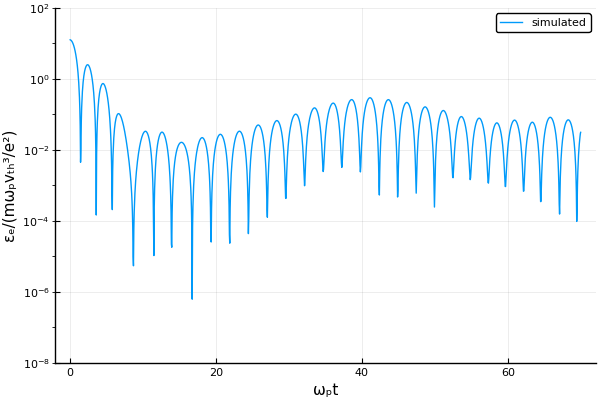

In [63]:
plot(t, ε_e, yscale=:log10, label="simulated")
ylims!(1e-8,1e2)
xlabel!("ωₚt")
ylabel!("εₑ/(mωₚvₜₕ³/e²)")

There is no analytical solution for strong landau damping. However the result can be compared to what has been obtained by other simulations. Our parameters are essentially the same as in the simulations performed in [\[Filbet et al. J. Comp. Phys. 172, 166–187 (2001)\]](https://doi.org/10.1006/jcph.2001.6818). So we can compare the curve presented above with the one plotted at Fig. 6(a) of this paper. It can be easily seen that the quantitative coincidence is almost perfect.